In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import medmnist
from medmnist import INFO, Evaluator
import torchvision.transforms as transforms
import torch.optim as optim

class CustomPneumoniaMNIST(Dataset):
    def __init__(self, npz_path, split='train', transform=None):
        if not os.path.exists(npz_path):
            raise FileNotFoundError(f"The .npz file '{npz_path}' does not exist.")

        with np.load(npz_path, allow_pickle=True) as data:
            images_key = f"{split}_images"
            labels_key = f"{split}_labels"
            if images_key not in data or labels_key not in data:
                raise KeyError(f"'{images_key}' or '{labels_key}' does not exist in the .npz file.")
            self.images = data[images_key]
            self.labels = data[labels_key]

        self.transform = transform

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx][0]

        img = Image.fromarray(img, mode='L')

        if self.transform:
            img = self.transform(img)

        return img, label



In [3]:
data_flag = 'pneumoniamnist'
download = False

NUM_EPOCHS = 30
BATCH_SIZE = 256
lr = 0.001
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])
info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DATA_ROOT = os.path.join('.')
npz_path = os.path.join(DATA_ROOT, 'pneumoniamnist.npz')

train_dataset = CustomPneumoniaMNIST(
    npz_path=npz_path,
    split='train',
    transform=data_transform
)
test_dataset = CustomPneumoniaMNIST(
    npz_path = os.path.join(DATA_ROOT, 'pneumoniamnist.npz'),
    split='test',
    transform=data_transform
)
val_dataset = CustomPneumoniaMNIST(
    npz_path = os.path.join(DATA_ROOT, 'pneumoniamnist.npz'),
    split='val',
    transform=data_transform
)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
print(train_dataset)
print("===================")
print(test_dataset)


In [4]:
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, in_channels=1, num_classes=2):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18(in_channels, num_classes):
    return ResNet(BasicBlock, [2, 2, 2, 2], in_channels=in_channels, num_classes=num_classes)

def ResNet50(in_channels, num_classes):
    return ResNet(Bottleneck, [3, 4, 6, 3], in_channels=in_channels, num_classes=num_classes)

if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()



In [46]:
DATA_ROOT = os.path.join('.')
train_dataset = CustomPneumoniaMNIST(
    npz_path=os.path.join(DATA_ROOT, 'pneumoniamnist.npz'),
    split='train',
    transform=data_transform
)
generated_npz_path = npz_path
augmented_train_data = np.load(generated_npz_path)

# Access images and labels
loaded_imgs = torch.tensor(augmented_train_data['train_images'])
loaded_labels = torch.tensor(augmented_train_data['train_labels'])


print(f"Images shape: {loaded_imgs.shape}")
print(f"Labels shape: {loaded_labels.shape}")
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
counter = Counter(train_dataset.labels.squeeze())
print (counter)
value = 2
print(f"The Value {value} appears {counter[value]} times in the list")

Images shape: torch.Size([4708, 28, 28])
Labels shape: torch.Size([4708, 1])
Counter({1: 3494, 0: 1214})
The Value 2 appears 0 times in the list


Training Epoch 1: 100%|██████████| 19/19 [00:03<00:00,  5.40it/s]


Epoch [1/30], Train Loss: 0.4509, Train Accuracy: 74.51%, Val Loss: 0.6527, Val Accuracy: 74.24%


Training Epoch 2: 100%|██████████| 19/19 [00:02<00:00,  7.99it/s]


Epoch [2/30], Train Loss: 0.1667, Train Accuracy: 93.52%, Val Loss: 0.8124, Val Accuracy: 74.24%


Training Epoch 3: 100%|██████████| 19/19 [00:02<00:00,  7.98it/s]


Epoch [3/30], Train Loss: 0.1106, Train Accuracy: 95.77%, Val Loss: 0.1149, Val Accuracy: 93.32%


Training Epoch 4: 100%|██████████| 19/19 [00:02<00:00,  8.04it/s]


Epoch [4/30], Train Loss: 0.0781, Train Accuracy: 97.26%, Val Loss: 0.0690, Val Accuracy: 95.99%


Training Epoch 5: 100%|██████████| 19/19 [00:02<00:00,  7.97it/s]


Epoch [5/30], Train Loss: 0.0575, Train Accuracy: 98.51%, Val Loss: 0.0721, Val Accuracy: 95.42%


Training Epoch 6: 100%|██████████| 19/19 [00:02<00:00,  7.99it/s]


Epoch [6/30], Train Loss: 0.0395, Train Accuracy: 99.17%, Val Loss: 0.0570, Val Accuracy: 96.18%


Training Epoch 7: 100%|██████████| 19/19 [00:02<00:00,  8.02it/s]


Epoch [7/30], Train Loss: 0.0264, Train Accuracy: 99.62%, Val Loss: 0.0512, Val Accuracy: 96.56%


Training Epoch 8: 100%|██████████| 19/19 [00:02<00:00,  7.98it/s]


Epoch [8/30], Train Loss: 0.0188, Train Accuracy: 99.87%, Val Loss: 0.0566, Val Accuracy: 96.95%


Training Epoch 9: 100%|██████████| 19/19 [00:02<00:00,  7.89it/s]


Epoch [9/30], Train Loss: 0.0128, Train Accuracy: 99.98%, Val Loss: 0.0465, Val Accuracy: 97.14%


Training Epoch 10: 100%|██████████| 19/19 [00:02<00:00,  7.82it/s]


Epoch [10/30], Train Loss: 0.0100, Train Accuracy: 99.98%, Val Loss: 0.0530, Val Accuracy: 96.56%


Training Epoch 11: 100%|██████████| 19/19 [00:02<00:00,  7.63it/s]


Epoch [11/30], Train Loss: 0.0071, Train Accuracy: 100.00%, Val Loss: 0.0469, Val Accuracy: 96.76%


Training Epoch 12: 100%|██████████| 19/19 [00:02<00:00,  7.76it/s]


Epoch [12/30], Train Loss: 0.0055, Train Accuracy: 100.00%, Val Loss: 0.0449, Val Accuracy: 96.76%


Training Epoch 13: 100%|██████████| 19/19 [00:02<00:00,  7.65it/s]


Epoch [13/30], Train Loss: 0.0042, Train Accuracy: 100.00%, Val Loss: 0.0428, Val Accuracy: 96.76%


Training Epoch 14: 100%|██████████| 19/19 [00:02<00:00,  7.61it/s]


Epoch [14/30], Train Loss: 0.0040, Train Accuracy: 100.00%, Val Loss: 0.0419, Val Accuracy: 96.95%


Training Epoch 15: 100%|██████████| 19/19 [00:02<00:00,  7.71it/s]


Epoch [15/30], Train Loss: 0.0033, Train Accuracy: 100.00%, Val Loss: 0.0425, Val Accuracy: 96.76%


Training Epoch 16: 100%|██████████| 19/19 [00:02<00:00,  7.72it/s]


Epoch [16/30], Train Loss: 0.0032, Train Accuracy: 100.00%, Val Loss: 0.0432, Val Accuracy: 96.95%


Training Epoch 17: 100%|██████████| 19/19 [00:02<00:00,  7.91it/s]


Epoch [17/30], Train Loss: 0.0028, Train Accuracy: 100.00%, Val Loss: 0.0434, Val Accuracy: 96.76%


Training Epoch 18: 100%|██████████| 19/19 [00:02<00:00,  7.82it/s]


Epoch [18/30], Train Loss: 0.0024, Train Accuracy: 100.00%, Val Loss: 0.0421, Val Accuracy: 96.95%


Training Epoch 19: 100%|██████████| 19/19 [00:02<00:00,  7.52it/s]


Epoch [19/30], Train Loss: 0.0020, Train Accuracy: 100.00%, Val Loss: 0.0421, Val Accuracy: 96.76%


Training Epoch 20: 100%|██████████| 19/19 [00:02<00:00,  7.69it/s]


Epoch [20/30], Train Loss: 0.0022, Train Accuracy: 100.00%, Val Loss: 0.0424, Val Accuracy: 97.14%


Training Epoch 21: 100%|██████████| 19/19 [00:02<00:00,  7.86it/s]


Epoch [21/30], Train Loss: 0.0016, Train Accuracy: 100.00%, Val Loss: 0.0414, Val Accuracy: 96.76%


Training Epoch 22: 100%|██████████| 19/19 [00:02<00:00,  7.67it/s]


Epoch [22/30], Train Loss: 0.0017, Train Accuracy: 100.00%, Val Loss: 0.0430, Val Accuracy: 97.14%


Training Epoch 23: 100%|██████████| 19/19 [00:02<00:00,  7.86it/s]


Epoch [23/30], Train Loss: 0.0016, Train Accuracy: 100.00%, Val Loss: 0.0421, Val Accuracy: 96.95%


Training Epoch 24: 100%|██████████| 19/19 [00:02<00:00,  6.94it/s]


Epoch [24/30], Train Loss: 0.0015, Train Accuracy: 100.00%, Val Loss: 0.0425, Val Accuracy: 96.95%


Training Epoch 25: 100%|██████████| 19/19 [00:02<00:00,  7.61it/s]


Epoch [25/30], Train Loss: 0.0015, Train Accuracy: 100.00%, Val Loss: 0.0416, Val Accuracy: 96.76%


Training Epoch 26: 100%|██████████| 19/19 [00:02<00:00,  7.36it/s]


Epoch [26/30], Train Loss: 0.0013, Train Accuracy: 100.00%, Val Loss: 0.0417, Val Accuracy: 96.95%


Training Epoch 27: 100%|██████████| 19/19 [00:02<00:00,  7.61it/s]


Epoch [27/30], Train Loss: 0.0011, Train Accuracy: 100.00%, Val Loss: 0.0413, Val Accuracy: 96.95%


Training Epoch 28: 100%|██████████| 19/19 [00:02<00:00,  7.74it/s]


Epoch [28/30], Train Loss: 0.0011, Train Accuracy: 100.00%, Val Loss: 0.0438, Val Accuracy: 97.14%


Training Epoch 29: 100%|██████████| 19/19 [00:02<00:00,  7.19it/s]


Epoch [29/30], Train Loss: 0.0009, Train Accuracy: 100.00%, Val Loss: 0.0426, Val Accuracy: 96.95%


Training Epoch 30: 100%|██████████| 19/19 [00:02<00:00,  7.74it/s]


Epoch [30/30], Train Loss: 0.0011, Train Accuracy: 100.00%, Val Loss: 0.0433, Val Accuracy: 96.95%


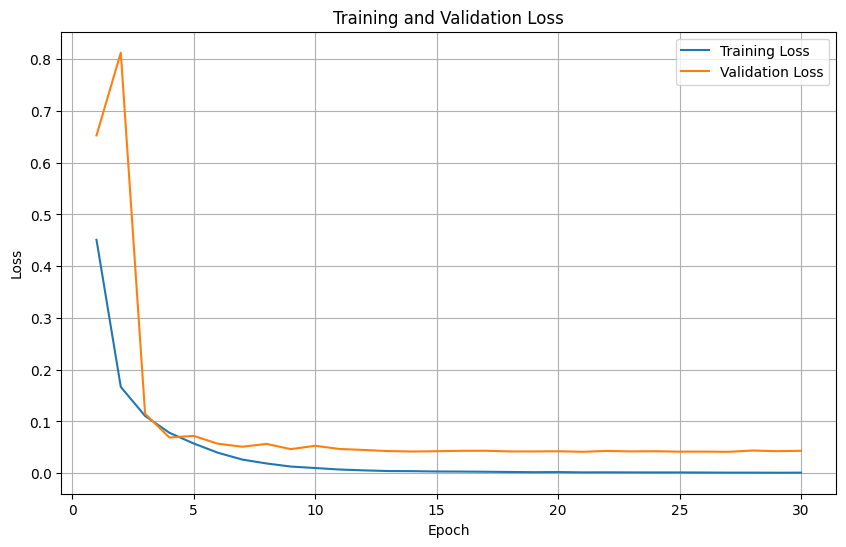

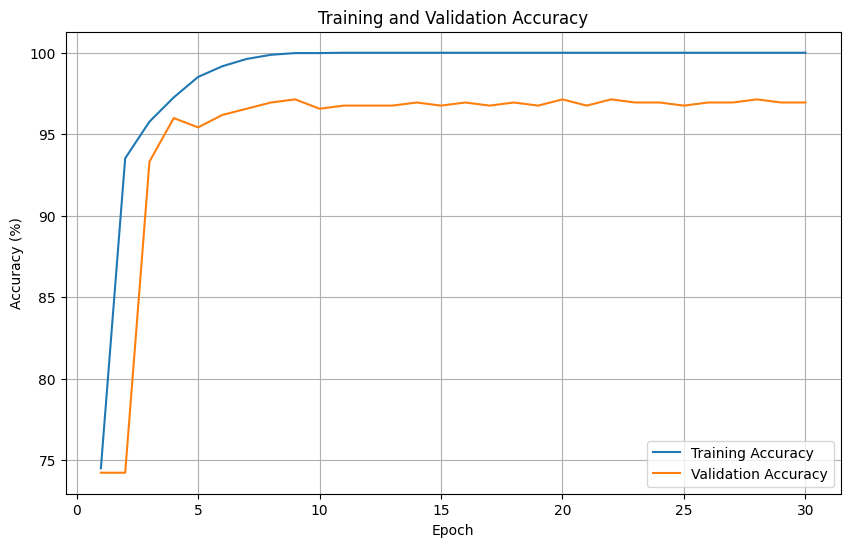

              precision    recall  f1-score   support

     Class 0       0.98      0.61      0.75       234
     Class 1       0.81      0.99      0.89       390

    accuracy                           0.85       624
   macro avg       0.89      0.80      0.82       624
weighted avg       0.87      0.85      0.84       624



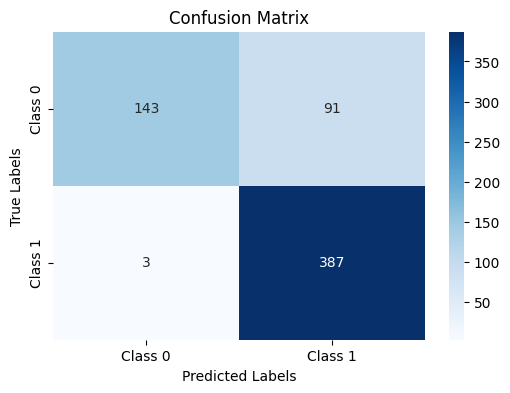

In [23]:
#origin resnet18
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
DATA_ROOT = os.path.join('.', 'origin')
train_dataset = CustomPneumoniaMNIST(
    npz_path=os.path.join(DATA_ROOT, 'pneumoniamnist.npz'),
    split='train',
    transform=data_transform
)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet18(in_channels=n_channels, num_classes=n_classes).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
criterion = nn.CrossEntropyLoss()
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
seed = 42
torch.manual_seed(seed)
# Training loop
for epoch in range(NUM_EPOCHS):
    model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, targets in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == targets).sum().item()
        total_train += targets.size(0)

    train_loss = running_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == targets).sum().item()
            total_val += targets.size(0)

    val_loss = running_val_loss / len(val_loader)
    val_accuracy = correct_val / total_val * 100
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Training Loss')
plt.plot(range(1, NUM_EPOCHS + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, NUM_EPOCHS + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, NUM_EPOCHS + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

# Evaluation on test data
all_preds = []
all_targets = []
model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

target_names = ["Class 0", "Class 1"]
report = classification_report(all_targets, all_preds, target_names=target_names)
print(report)

# 生成混淆矩阵
cm = confusion_matrix(all_targets, all_preds)

# 绘制混淆矩阵热图
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



In [72]:
import numpy as np
DATA_ROOT = os.path.join('.','origin')
npz_path=os.path.join(DATA_ROOT, 'pneumoniamnist.npz')
# 加载 npz 文件
file_path = npz_path # 替换为你的 .npz 文件路径
data = np.load(file_path)

# 输出键名和数据维度
print("文件中的键名及其对应维度：")
for key in data.keys():
    print(f"{key}: {data[key].shape}")

# 加载 npz 文件

# 检查是否存在 'label' 键
if 'train_labels' in data:
    labels = data['train_labels']  # 提取 label 数据
    print("Label 的前 10 个值：")
    print(labels[:10])  # 输出前 10 个值

print("文件中的所有键名：")
print(list(data.keys()))


文件中的键名及其对应维度：
train_images: (4708, 28, 28)
val_images: (524, 28, 28)
test_images: (624, 28, 28)
train_labels: (4708, 1)
val_labels: (524, 1)
test_labels: (624, 1)
Label 的前 10 个值：
[[1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]]
文件中的所有键名：
['train_images', 'val_images', 'test_images', 'train_labels', 'val_labels', 'test_labels']


In [60]:
DATA_ROOT = os.path.join('.','DCGAN')
train_dataset = CustomPneumoniaMNIST(
    npz_path=os.path.join(DATA_ROOT, 'Merge_DCGAN_data.npz'),
    split='train',
    transform=data_transform
)
generated_npz_path = npz_path
augmented_train_data = np.load(generated_npz_path)

# Access images and labels
loaded_imgs = torch.tensor(augmented_train_data['train_images'])
loaded_labels = torch.tensor(augmented_train_data['train_labels'])


print(f"Images shape: {loaded_imgs.shape}")
print(f"Labels shape: {loaded_labels.shape}")
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
counter = Counter(train_dataset.labels.squeeze())
print (counter)
value = 2
print(f"The Value {value} appears {counter[value]} times in the list")

Images shape: torch.Size([4708, 28, 28])
Labels shape: torch.Size([4708, 1])
Counter({0: 3494, 1: 3494})
The Value 2 appears 0 times in the list


In [73]:
import numpy as np
DATA_ROOT = os.path.join('.','DCGAN')
npz_path=os.path.join(DATA_ROOT, 'Merge_DCGAN_data.npz')
# 加载 npz 文件
file_path = npz_path # 替换为你的 .npz 文件路径
data = np.load(file_path)

# 输出键名和数据维度
print("文件中的键名及其对应维度：")
for key in data.keys():
    print(f"{key}: {data[key].shape}")

# 加载 npz 文件

# 检查是否存在 'label' 键
if 'train_labels' in data:
    labels = data['train_labels']  # 提取 label 数据
    print("Label 的前 10 个值：")
    print(labels[:10])  # 输出前 10 个值

print("文件中的所有键名：")
print(list(data.keys()))


文件中的键名及其对应维度：
train_images: (6988, 28, 28)
train_labels: (6988,)
test_images: (624, 28, 28)
test_labels: (624,)
val_images: (524, 28, 28)
val_labels: (524,)
Label 的前 10 个值：
[0 0 0 1 0 0 0 1 0 0]
文件中的所有键名：
['train_images', 'train_labels', 'test_images', 'test_labels', 'val_images', 'val_labels']


In [74]:
import numpy as np

# 加载 npz 文件
file_path = npz_path  # 替换为图二对应的文件路径
data = np.load(file_path)

# 创建新的字典，调整标签维度
new_data = {}
for key in data.keys():
    if 'labels' in key:  # 对包含 'labels' 的键调整维度
        new_data[key] = data[key].reshape(-1, 1)  # 转为二维数组
    else:
        new_data[key] = data[key]  # 保持其他数据不变

# 保存新的 npz 文件
new_file_path =os.path.join(DATA_ROOT, 'Merge_DCGAN_data1.npz')  # 新文件路径
np.savez(new_file_path, **new_data)

print(f"已将标签维度调整为二维数组，保存为 {new_file_path}")


已将标签维度调整为二维数组，保存为 .\DCGAN\Merge_DCGAN_data1.npz


Training Epoch 1: 100%|██████████| 28/28 [00:05<00:00,  5.36it/s]


Epoch [1/30], Train Loss: 0.3140, Train Accuracy: 84.72%, Val Loss: 1.0354, Val Accuracy: 74.24%


Training Epoch 2: 100%|██████████| 28/28 [00:05<00:00,  5.12it/s]


Epoch [2/30], Train Loss: 0.0997, Train Accuracy: 96.42%, Val Loss: 0.1665, Val Accuracy: 92.18%


Training Epoch 3: 100%|██████████| 28/28 [00:05<00:00,  5.21it/s]


Epoch [3/30], Train Loss: 0.0660, Train Accuracy: 97.70%, Val Loss: 0.0904, Val Accuracy: 95.42%


Training Epoch 4: 100%|██████████| 28/28 [00:05<00:00,  5.60it/s]


Epoch [4/30], Train Loss: 0.0461, Train Accuracy: 98.64%, Val Loss: 0.0883, Val Accuracy: 95.80%


Training Epoch 5: 100%|██████████| 28/28 [00:05<00:00,  5.53it/s]


Epoch [5/30], Train Loss: 0.0313, Train Accuracy: 99.27%, Val Loss: 0.0773, Val Accuracy: 95.80%


Training Epoch 6: 100%|██████████| 28/28 [00:05<00:00,  5.53it/s]


Epoch [6/30], Train Loss: 0.0219, Train Accuracy: 99.66%, Val Loss: 0.0674, Val Accuracy: 96.18%


Training Epoch 7: 100%|██████████| 28/28 [00:05<00:00,  5.18it/s]


Epoch [7/30], Train Loss: 0.0134, Train Accuracy: 99.90%, Val Loss: 0.0600, Val Accuracy: 96.37%


Training Epoch 8: 100%|██████████| 28/28 [00:05<00:00,  5.06it/s]


Epoch [8/30], Train Loss: 0.0102, Train Accuracy: 99.96%, Val Loss: 0.0594, Val Accuracy: 95.80%


Training Epoch 9: 100%|██████████| 28/28 [00:05<00:00,  5.09it/s]


Epoch [9/30], Train Loss: 0.0081, Train Accuracy: 99.97%, Val Loss: 0.0582, Val Accuracy: 95.61%


Training Epoch 10: 100%|██████████| 28/28 [00:05<00:00,  5.12it/s]


Epoch [10/30], Train Loss: 0.0053, Train Accuracy: 100.00%, Val Loss: 0.0580, Val Accuracy: 95.99%


Training Epoch 11: 100%|██████████| 28/28 [00:05<00:00,  4.96it/s]


Epoch [11/30], Train Loss: 0.0041, Train Accuracy: 100.00%, Val Loss: 0.0574, Val Accuracy: 96.18%


Training Epoch 12: 100%|██████████| 28/28 [00:05<00:00,  5.04it/s]


Epoch [12/30], Train Loss: 0.0035, Train Accuracy: 100.00%, Val Loss: 0.0553, Val Accuracy: 95.61%


Training Epoch 13: 100%|██████████| 28/28 [00:05<00:00,  5.05it/s]


Epoch [13/30], Train Loss: 0.0027, Train Accuracy: 100.00%, Val Loss: 0.0612, Val Accuracy: 96.76%


Training Epoch 14: 100%|██████████| 28/28 [00:05<00:00,  5.13it/s]


Epoch [14/30], Train Loss: 0.0022, Train Accuracy: 100.00%, Val Loss: 0.0579, Val Accuracy: 96.56%


Training Epoch 15: 100%|██████████| 28/28 [00:05<00:00,  5.16it/s]


Epoch [15/30], Train Loss: 0.0018, Train Accuracy: 100.00%, Val Loss: 0.0549, Val Accuracy: 95.80%


Training Epoch 16: 100%|██████████| 28/28 [00:06<00:00,  4.65it/s]


Epoch [16/30], Train Loss: 0.0016, Train Accuracy: 100.00%, Val Loss: 0.0547, Val Accuracy: 95.99%


Training Epoch 17: 100%|██████████| 28/28 [00:05<00:00,  5.40it/s]


Epoch [17/30], Train Loss: 0.0016, Train Accuracy: 100.00%, Val Loss: 0.0556, Val Accuracy: 95.99%


Training Epoch 18: 100%|██████████| 28/28 [00:05<00:00,  5.40it/s]


Epoch [18/30], Train Loss: 0.0014, Train Accuracy: 100.00%, Val Loss: 0.0547, Val Accuracy: 95.80%


Training Epoch 19: 100%|██████████| 28/28 [00:05<00:00,  5.33it/s]


Epoch [19/30], Train Loss: 0.0013, Train Accuracy: 100.00%, Val Loss: 0.0549, Val Accuracy: 95.99%


Training Epoch 20: 100%|██████████| 28/28 [00:05<00:00,  5.15it/s]


Epoch [20/30], Train Loss: 0.0011, Train Accuracy: 100.00%, Val Loss: 0.0543, Val Accuracy: 95.99%


Training Epoch 21: 100%|██████████| 28/28 [00:05<00:00,  5.06it/s]


Epoch [21/30], Train Loss: 0.0010, Train Accuracy: 100.00%, Val Loss: 0.0534, Val Accuracy: 95.80%


Training Epoch 22: 100%|██████████| 28/28 [00:05<00:00,  4.96it/s]


Epoch [22/30], Train Loss: 0.0011, Train Accuracy: 100.00%, Val Loss: 0.0542, Val Accuracy: 95.99%


Training Epoch 23: 100%|██████████| 28/28 [00:05<00:00,  4.97it/s]


Epoch [23/30], Train Loss: 0.0009, Train Accuracy: 100.00%, Val Loss: 0.0534, Val Accuracy: 95.80%


Training Epoch 24: 100%|██████████| 28/28 [00:05<00:00,  5.02it/s]


Epoch [24/30], Train Loss: 0.0010, Train Accuracy: 100.00%, Val Loss: 0.0578, Val Accuracy: 96.37%


Training Epoch 25: 100%|██████████| 28/28 [00:05<00:00,  5.04it/s]


Epoch [25/30], Train Loss: 0.0008, Train Accuracy: 100.00%, Val Loss: 0.0551, Val Accuracy: 95.80%


Training Epoch 26: 100%|██████████| 28/28 [00:05<00:00,  4.90it/s]


Epoch [26/30], Train Loss: 0.0007, Train Accuracy: 100.00%, Val Loss: 0.0540, Val Accuracy: 95.80%


Training Epoch 27: 100%|██████████| 28/28 [00:05<00:00,  4.78it/s]


Epoch [27/30], Train Loss: 0.0006, Train Accuracy: 100.00%, Val Loss: 0.0548, Val Accuracy: 95.99%


Training Epoch 28: 100%|██████████| 28/28 [00:05<00:00,  4.99it/s]


Epoch [28/30], Train Loss: 0.0008, Train Accuracy: 100.00%, Val Loss: 0.0556, Val Accuracy: 95.99%


Training Epoch 29: 100%|██████████| 28/28 [00:05<00:00,  5.28it/s]


Epoch [29/30], Train Loss: 0.0006, Train Accuracy: 100.00%, Val Loss: 0.0548, Val Accuracy: 96.37%


Training Epoch 30: 100%|██████████| 28/28 [00:05<00:00,  5.20it/s]


Epoch [30/30], Train Loss: 0.0006, Train Accuracy: 100.00%, Val Loss: 0.0547, Val Accuracy: 95.99%


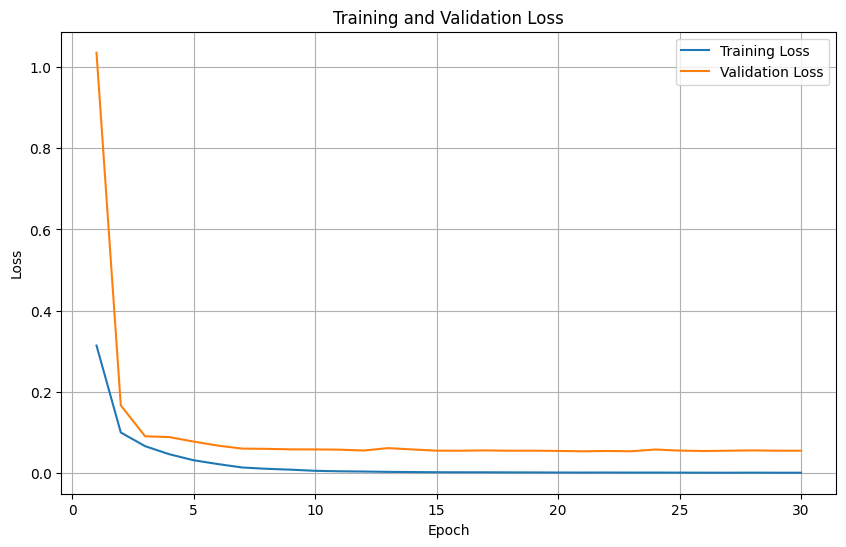

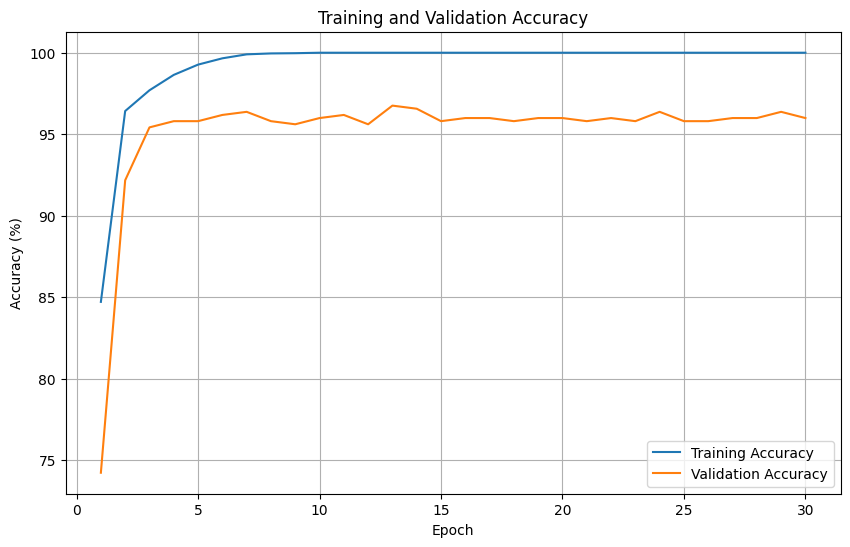

              precision    recall  f1-score   support

     Class 0       0.98      0.62      0.76       234
     Class 1       0.81      0.99      0.89       390

    accuracy                           0.85       624
   macro avg       0.90      0.81      0.83       624
weighted avg       0.88      0.85      0.85       624



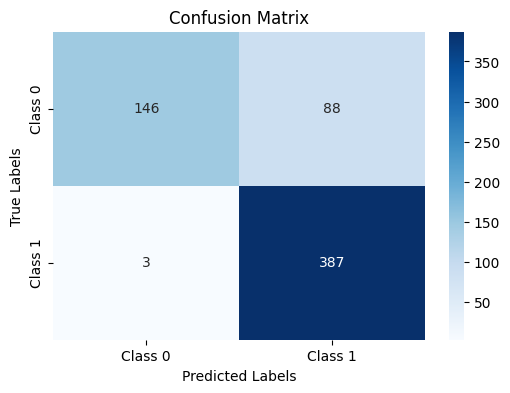

In [75]:
#DCGAN resnet18
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
DATA_ROOT = os.path.join('.', 'DCGAN')
train_dataset = CustomPneumoniaMNIST(
    npz_path=os.path.join(DATA_ROOT, 'Merge_DCGAN_data1.npz'),
    split='train',
    transform=data_transform
)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet18(in_channels=n_channels, num_classes=n_classes).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
criterion = nn.CrossEntropyLoss()
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
seed = 42
torch.manual_seed(seed)

# Training loop
for epoch in range(NUM_EPOCHS):
    model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, targets in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == targets).sum().item()
        total_train += targets.size(0)

    train_loss = running_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == targets).sum().item()
            total_val += targets.size(0)

    val_loss = running_val_loss / len(val_loader)
    val_accuracy = correct_val / total_val * 100
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Training Loss')
plt.plot(range(1, NUM_EPOCHS + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, NUM_EPOCHS + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, NUM_EPOCHS + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

# Evaluation on test data
all_preds = []
all_targets = []
model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

target_names = ["Class 0", "Class 1"]
report = classification_report(all_targets, all_preds, target_names=target_names)
print(report)

# 生成混淆矩阵
cm = confusion_matrix(all_targets, all_preds)

# 绘制混淆矩阵热图
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



In [76]:
import numpy as np
DATA_ROOT = os.path.join('.','augmented')
npz_path=os.path.join(DATA_ROOT, 'Merge_aug_data.npz')
# 加载 npz 文件
file_path = npz_path # 替换为你的 .npz 文件路径
data = np.load(file_path)

# 输出键名和数据维度
print("文件中的键名及其对应维度：")
for key in data.keys():
    print(f"{key}: {data[key].shape}")

# 加载 npz 文件

# 检查是否存在 'label' 键
if 'train_labels' in data:
    labels = data['train_labels']  # 提取 label 数据
    print("Label 的前 10 个值：")
    print(labels[:10])  # 输出前 10 个值

print("文件中的所有键名：")
print(list(data.keys()))


文件中的键名及其对应维度：
train_images: (6988, 28, 28)
train_labels: (6988,)
test_images: (624, 28, 28)
test_labels: (624,)
val_images: (524, 28, 28)
val_labels: (524,)
Label 的前 10 个值：
[0 0 0 1 0 0 0 1 0 0]
文件中的所有键名：
['train_images', 'train_labels', 'test_images', 'test_labels', 'val_images', 'val_labels']


In [80]:
import numpy as np

# 加载 npz 文件
file_path = npz_path  # 替换为图二对应的文件路径
data = np.load(file_path)

# 创建新的字典，调整标签维度
new_data = {}
for key in data.keys():
    if 'labels' in key:  # 对包含 'labels' 的键调整维度
        new_data[key] = data[key].reshape(-1, 1)  # 转为二维数组
    else:
        new_data[key] = data[key]  # 保持其他数据不变

# 保存新的 npz 文件
new_file_path =os.path.join(DATA_ROOT, 'Merge_aug_data1.npz')  # 新文件路径
np.savez(new_file_path, **new_data)

print(f"已将标签维度调整为二维数组，保存为 {new_file_path}")


已将标签维度调整为二维数组，保存为 .\augmented\Merge_aug_data1.npz


Training Epoch 1: 100%|██████████| 28/28 [00:05<00:00,  5.13it/s]


Epoch [1/30], Train Loss: 0.3737, Train Accuracy: 81.48%, Val Loss: 0.8466, Val Accuracy: 74.24%


Training Epoch 2: 100%|██████████| 28/28 [00:05<00:00,  5.35it/s]


Epoch [2/30], Train Loss: 0.1220, Train Accuracy: 95.25%, Val Loss: 0.1800, Val Accuracy: 88.55%


Training Epoch 3: 100%|██████████| 28/28 [00:05<00:00,  5.28it/s]


Epoch [3/30], Train Loss: 0.0780, Train Accuracy: 97.34%, Val Loss: 0.0740, Val Accuracy: 95.23%


Training Epoch 4: 100%|██████████| 28/28 [00:05<00:00,  5.23it/s]


Epoch [4/30], Train Loss: 0.0519, Train Accuracy: 98.50%, Val Loss: 0.0705, Val Accuracy: 95.42%


Training Epoch 5: 100%|██████████| 28/28 [00:05<00:00,  5.07it/s]


Epoch [5/30], Train Loss: 0.0340, Train Accuracy: 99.27%, Val Loss: 0.0597, Val Accuracy: 95.80%


Training Epoch 6: 100%|██████████| 28/28 [00:05<00:00,  5.05it/s]


Epoch [6/30], Train Loss: 0.0218, Train Accuracy: 99.79%, Val Loss: 0.0571, Val Accuracy: 95.80%


Training Epoch 7: 100%|██████████| 28/28 [00:05<00:00,  5.14it/s]


Epoch [7/30], Train Loss: 0.0132, Train Accuracy: 99.94%, Val Loss: 0.0560, Val Accuracy: 96.18%


Training Epoch 8: 100%|██████████| 28/28 [00:05<00:00,  5.29it/s]


Epoch [8/30], Train Loss: 0.0099, Train Accuracy: 99.99%, Val Loss: 0.0541, Val Accuracy: 96.95%


Training Epoch 9: 100%|██████████| 28/28 [00:05<00:00,  5.25it/s]


Epoch [9/30], Train Loss: 0.0083, Train Accuracy: 99.97%, Val Loss: 0.0552, Val Accuracy: 96.37%


Training Epoch 10: 100%|██████████| 28/28 [00:05<00:00,  5.25it/s]


Epoch [10/30], Train Loss: 0.0058, Train Accuracy: 100.00%, Val Loss: 0.0576, Val Accuracy: 96.37%


Training Epoch 11: 100%|██████████| 28/28 [00:05<00:00,  5.34it/s]


Epoch [11/30], Train Loss: 0.0043, Train Accuracy: 100.00%, Val Loss: 0.0577, Val Accuracy: 96.18%


Training Epoch 12: 100%|██████████| 28/28 [00:05<00:00,  5.24it/s]


Epoch [12/30], Train Loss: 0.0039, Train Accuracy: 100.00%, Val Loss: 0.0552, Val Accuracy: 96.56%


Training Epoch 13: 100%|██████████| 28/28 [00:05<00:00,  5.22it/s]


Epoch [13/30], Train Loss: 0.0027, Train Accuracy: 100.00%, Val Loss: 0.0579, Val Accuracy: 95.80%


Training Epoch 14: 100%|██████████| 28/28 [00:05<00:00,  5.13it/s]


Epoch [14/30], Train Loss: 0.0023, Train Accuracy: 100.00%, Val Loss: 0.0618, Val Accuracy: 95.99%


Training Epoch 15: 100%|██████████| 28/28 [00:05<00:00,  5.05it/s]


Epoch [15/30], Train Loss: 0.0019, Train Accuracy: 100.00%, Val Loss: 0.0580, Val Accuracy: 95.80%


Training Epoch 16: 100%|██████████| 28/28 [00:05<00:00,  4.97it/s]


Epoch [16/30], Train Loss: 0.0018, Train Accuracy: 100.00%, Val Loss: 0.0571, Val Accuracy: 96.37%


Training Epoch 17: 100%|██████████| 28/28 [00:05<00:00,  4.84it/s]


Epoch [17/30], Train Loss: 0.0018, Train Accuracy: 100.00%, Val Loss: 0.0582, Val Accuracy: 95.99%


Training Epoch 18: 100%|██████████| 28/28 [00:05<00:00,  5.04it/s]


Epoch [18/30], Train Loss: 0.0016, Train Accuracy: 100.00%, Val Loss: 0.0571, Val Accuracy: 96.18%


Training Epoch 19: 100%|██████████| 28/28 [00:06<00:00,  4.61it/s]


Epoch [19/30], Train Loss: 0.0013, Train Accuracy: 100.00%, Val Loss: 0.0576, Val Accuracy: 96.37%


Training Epoch 20: 100%|██████████| 28/28 [00:05<00:00,  5.03it/s]


Epoch [20/30], Train Loss: 0.0012, Train Accuracy: 100.00%, Val Loss: 0.0579, Val Accuracy: 96.37%


Training Epoch 21: 100%|██████████| 28/28 [00:05<00:00,  5.05it/s]


Epoch [21/30], Train Loss: 0.0012, Train Accuracy: 100.00%, Val Loss: 0.0572, Val Accuracy: 96.18%


Training Epoch 22: 100%|██████████| 28/28 [00:05<00:00,  5.02it/s]


Epoch [22/30], Train Loss: 0.0012, Train Accuracy: 100.00%, Val Loss: 0.0589, Val Accuracy: 96.37%


Training Epoch 23: 100%|██████████| 28/28 [00:05<00:00,  4.88it/s]


Epoch [23/30], Train Loss: 0.0011, Train Accuracy: 100.00%, Val Loss: 0.0598, Val Accuracy: 96.18%


Training Epoch 24: 100%|██████████| 28/28 [00:05<00:00,  4.85it/s]


Epoch [24/30], Train Loss: 0.0011, Train Accuracy: 100.00%, Val Loss: 0.0606, Val Accuracy: 96.37%


Training Epoch 25: 100%|██████████| 28/28 [00:05<00:00,  5.00it/s]


Epoch [25/30], Train Loss: 0.0009, Train Accuracy: 100.00%, Val Loss: 0.0580, Val Accuracy: 96.18%


Training Epoch 26: 100%|██████████| 28/28 [00:05<00:00,  5.28it/s]


Epoch [26/30], Train Loss: 0.0008, Train Accuracy: 100.00%, Val Loss: 0.0582, Val Accuracy: 96.37%


Training Epoch 27: 100%|██████████| 28/28 [00:05<00:00,  5.22it/s]


Epoch [27/30], Train Loss: 0.0007, Train Accuracy: 100.00%, Val Loss: 0.0590, Val Accuracy: 96.37%


Training Epoch 28: 100%|██████████| 28/28 [00:05<00:00,  5.11it/s]


Epoch [28/30], Train Loss: 0.0009, Train Accuracy: 100.00%, Val Loss: 0.0574, Val Accuracy: 96.37%


Training Epoch 29: 100%|██████████| 28/28 [00:05<00:00,  5.06it/s]


Epoch [29/30], Train Loss: 0.0006, Train Accuracy: 100.00%, Val Loss: 0.0606, Val Accuracy: 96.37%


Training Epoch 30: 100%|██████████| 28/28 [00:05<00:00,  5.12it/s]


Epoch [30/30], Train Loss: 0.0006, Train Accuracy: 100.00%, Val Loss: 0.0606, Val Accuracy: 96.37%


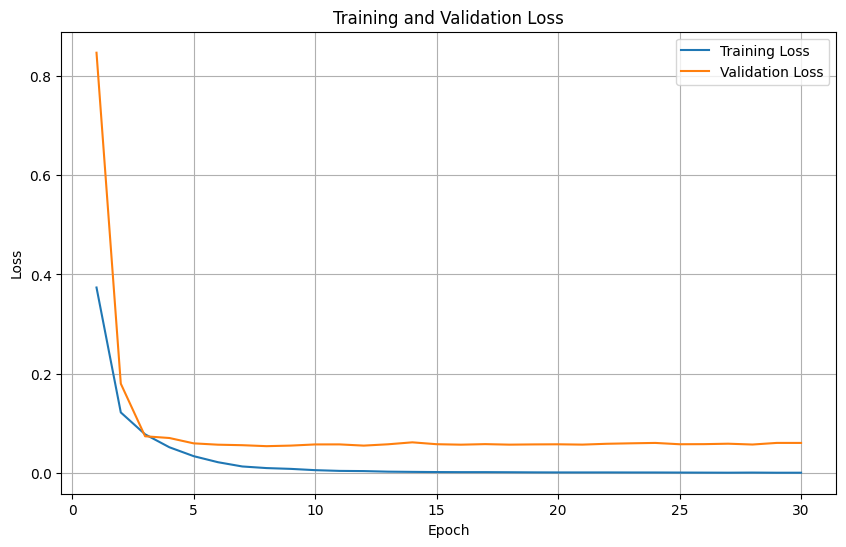

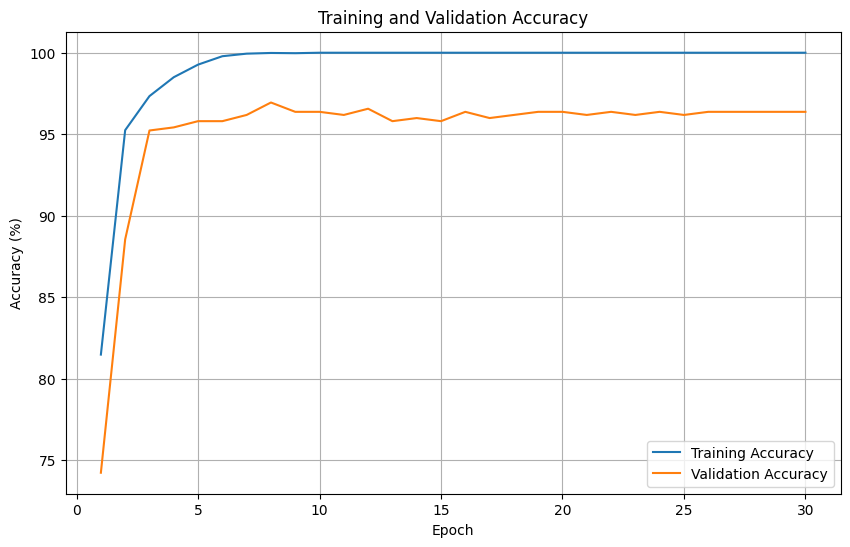

              precision    recall  f1-score   support

     Class 0       0.97      0.62      0.76       234
     Class 1       0.81      0.99      0.89       390

    accuracy                           0.85       624
   macro avg       0.89      0.81      0.83       624
weighted avg       0.87      0.85      0.84       624



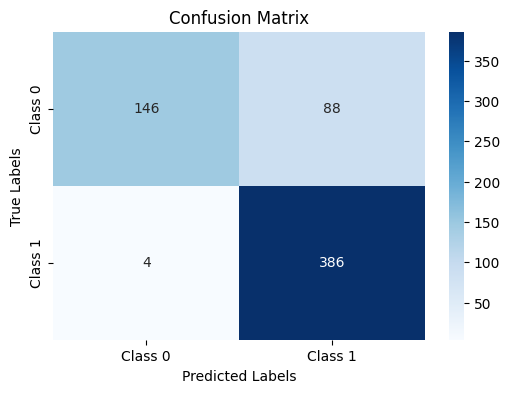

In [81]:
#augmented resnet18
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
DATA_ROOT = os.path.join('.', 'augmented')
train_dataset = CustomPneumoniaMNIST(
    npz_path=os.path.join(DATA_ROOT, 'Merge_aug_data1.npz'),
    split='train',
    transform=data_transform
)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet18(in_channels=n_channels, num_classes=n_classes).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
criterion = nn.CrossEntropyLoss()
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
seed = 42
torch.manual_seed(seed)
# Training loop
for epoch in range(NUM_EPOCHS):
    model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, targets in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == targets).sum().item()
        total_train += targets.size(0)

    train_loss = running_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == targets).sum().item()
            total_val += targets.size(0)

    val_loss = running_val_loss / len(val_loader)
    val_accuracy = correct_val / total_val * 100
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Training Loss')
plt.plot(range(1, NUM_EPOCHS + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, NUM_EPOCHS + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, NUM_EPOCHS + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

# Evaluation on test data
all_preds = []
all_targets = []
model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

target_names = ["Class 0", "Class 1"]
report = classification_report(all_targets, all_preds, target_names=target_names)
print(report)

# 生成混淆矩阵
cm = confusion_matrix(all_targets, all_preds)

# 绘制混淆矩阵热图
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



In [5]:
generated_npz_path = "train_data_acgan(o).npz"
augmented_train_data = np.load(generated_npz_path)

# Access images and labels
loaded_imgs = torch.tensor(augmented_train_data['images'])
loaded_labels = torch.tensor(augmented_train_data['labels'])


print(f"Images shape: {loaded_imgs.shape}")
print(f"Labels shape: {loaded_labels.shape}")

train_dataset = torch.utils.data.TensorDataset(loaded_imgs.detach(), loaded_labels.detach().long())

Images shape: torch.Size([6988, 1, 28, 28])
Labels shape: torch.Size([6988])


Training Epoch 1: 100%|██████████| 28/28 [00:03<00:00,  8.30it/s]


Epoch [1/30], Train Loss: 0.4407, Train Accuracy: 78.78%, Val Loss: 0.7643, Val Accuracy: 74.24%


Training Epoch 2: 100%|██████████| 28/28 [00:03<00:00,  8.92it/s]


Epoch [2/30], Train Loss: 0.1506, Train Accuracy: 94.99%, Val Loss: 0.1427, Val Accuracy: 94.08%


Training Epoch 3: 100%|██████████| 28/28 [00:03<00:00,  8.94it/s]


Epoch [3/30], Train Loss: 0.0758, Train Accuracy: 97.41%, Val Loss: 0.1429, Val Accuracy: 95.61%


Training Epoch 4: 100%|██████████| 28/28 [00:03<00:00,  8.96it/s]


Epoch [4/30], Train Loss: 0.0501, Train Accuracy: 98.38%, Val Loss: 0.1093, Val Accuracy: 96.56%


Training Epoch 5: 100%|██████████| 28/28 [00:03<00:00,  8.92it/s]


Epoch [5/30], Train Loss: 0.0323, Train Accuracy: 99.23%, Val Loss: 0.1141, Val Accuracy: 96.95%


Training Epoch 6: 100%|██████████| 28/28 [00:03<00:00,  8.96it/s]


Epoch [6/30], Train Loss: 0.0216, Train Accuracy: 99.66%, Val Loss: 0.0931, Val Accuracy: 96.37%


Training Epoch 7: 100%|██████████| 28/28 [00:03<00:00,  8.97it/s]


Epoch [7/30], Train Loss: 0.0130, Train Accuracy: 99.93%, Val Loss: 0.1287, Val Accuracy: 96.76%


Training Epoch 8: 100%|██████████| 28/28 [00:03<00:00,  8.96it/s]


Epoch [8/30], Train Loss: 0.0091, Train Accuracy: 99.97%, Val Loss: 0.1167, Val Accuracy: 97.52%


Training Epoch 9: 100%|██████████| 28/28 [00:03<00:00,  8.99it/s]


Epoch [9/30], Train Loss: 0.0068, Train Accuracy: 99.99%, Val Loss: 0.0718, Val Accuracy: 97.33%


Training Epoch 10: 100%|██████████| 28/28 [00:03<00:00,  8.95it/s]


Epoch [10/30], Train Loss: 0.0048, Train Accuracy: 100.00%, Val Loss: 0.0744, Val Accuracy: 96.95%


Training Epoch 11: 100%|██████████| 28/28 [00:03<00:00,  8.94it/s]


Epoch [11/30], Train Loss: 0.0039, Train Accuracy: 100.00%, Val Loss: 0.0794, Val Accuracy: 96.95%


Training Epoch 12: 100%|██████████| 28/28 [00:03<00:00,  8.95it/s]


Epoch [12/30], Train Loss: 0.0032, Train Accuracy: 100.00%, Val Loss: 0.0773, Val Accuracy: 97.14%


Training Epoch 13: 100%|██████████| 28/28 [00:03<00:00,  8.94it/s]


Epoch [13/30], Train Loss: 0.0027, Train Accuracy: 100.00%, Val Loss: 0.0898, Val Accuracy: 97.14%


Training Epoch 14: 100%|██████████| 28/28 [00:03<00:00,  8.12it/s]


Epoch [14/30], Train Loss: 0.0024, Train Accuracy: 100.00%, Val Loss: 0.0766, Val Accuracy: 97.14%


Training Epoch 15: 100%|██████████| 28/28 [00:03<00:00,  8.97it/s]


Epoch [15/30], Train Loss: 0.0021, Train Accuracy: 100.00%, Val Loss: 0.0766, Val Accuracy: 97.14%


Training Epoch 16: 100%|██████████| 28/28 [00:03<00:00,  8.95it/s]


Epoch [16/30], Train Loss: 0.0018, Train Accuracy: 100.00%, Val Loss: 0.0768, Val Accuracy: 97.14%


Training Epoch 17: 100%|██████████| 28/28 [00:03<00:00,  8.93it/s]


Epoch [17/30], Train Loss: 0.0017, Train Accuracy: 100.00%, Val Loss: 0.0757, Val Accuracy: 97.14%


Training Epoch 18: 100%|██████████| 28/28 [00:03<00:00,  8.99it/s]


Epoch [18/30], Train Loss: 0.0015, Train Accuracy: 100.00%, Val Loss: 0.0717, Val Accuracy: 96.95%


Training Epoch 19: 100%|██████████| 28/28 [00:03<00:00,  8.94it/s]


Epoch [19/30], Train Loss: 0.0014, Train Accuracy: 100.00%, Val Loss: 0.0811, Val Accuracy: 97.14%


Training Epoch 20: 100%|██████████| 28/28 [00:03<00:00,  8.95it/s]


Epoch [20/30], Train Loss: 0.0014, Train Accuracy: 100.00%, Val Loss: 0.0708, Val Accuracy: 96.95%


Training Epoch 21: 100%|██████████| 28/28 [00:03<00:00,  8.99it/s]


Epoch [21/30], Train Loss: 0.0013, Train Accuracy: 100.00%, Val Loss: 0.0744, Val Accuracy: 97.14%


Training Epoch 22: 100%|██████████| 28/28 [00:03<00:00,  8.94it/s]


Epoch [22/30], Train Loss: 0.0010, Train Accuracy: 100.00%, Val Loss: 0.0823, Val Accuracy: 97.14%


Training Epoch 23: 100%|██████████| 28/28 [00:03<00:00,  8.94it/s]


Epoch [23/30], Train Loss: 0.0010, Train Accuracy: 100.00%, Val Loss: 0.0743, Val Accuracy: 96.95%


Training Epoch 24: 100%|██████████| 28/28 [00:03<00:00,  8.88it/s]


Epoch [24/30], Train Loss: 0.0008, Train Accuracy: 100.00%, Val Loss: 0.0755, Val Accuracy: 96.95%


Training Epoch 25: 100%|██████████| 28/28 [00:03<00:00,  8.96it/s]


Epoch [25/30], Train Loss: 0.0008, Train Accuracy: 100.00%, Val Loss: 0.0730, Val Accuracy: 96.95%


Training Epoch 26: 100%|██████████| 28/28 [00:03<00:00,  8.94it/s]


Epoch [26/30], Train Loss: 0.0008, Train Accuracy: 100.00%, Val Loss: 0.0766, Val Accuracy: 97.14%


Training Epoch 27: 100%|██████████| 28/28 [00:03<00:00,  8.93it/s]


Epoch [27/30], Train Loss: 0.0009, Train Accuracy: 100.00%, Val Loss: 0.0696, Val Accuracy: 96.95%


Training Epoch 28: 100%|██████████| 28/28 [00:03<00:00,  8.96it/s]


Epoch [28/30], Train Loss: 0.0007, Train Accuracy: 100.00%, Val Loss: 0.0725, Val Accuracy: 96.95%


Training Epoch 29: 100%|██████████| 28/28 [00:03<00:00,  8.97it/s]


Epoch [29/30], Train Loss: 0.0006, Train Accuracy: 100.00%, Val Loss: 0.0712, Val Accuracy: 96.95%


Training Epoch 30: 100%|██████████| 28/28 [00:03<00:00,  8.94it/s]


Epoch [30/30], Train Loss: 0.0006, Train Accuracy: 100.00%, Val Loss: 0.0790, Val Accuracy: 97.14%


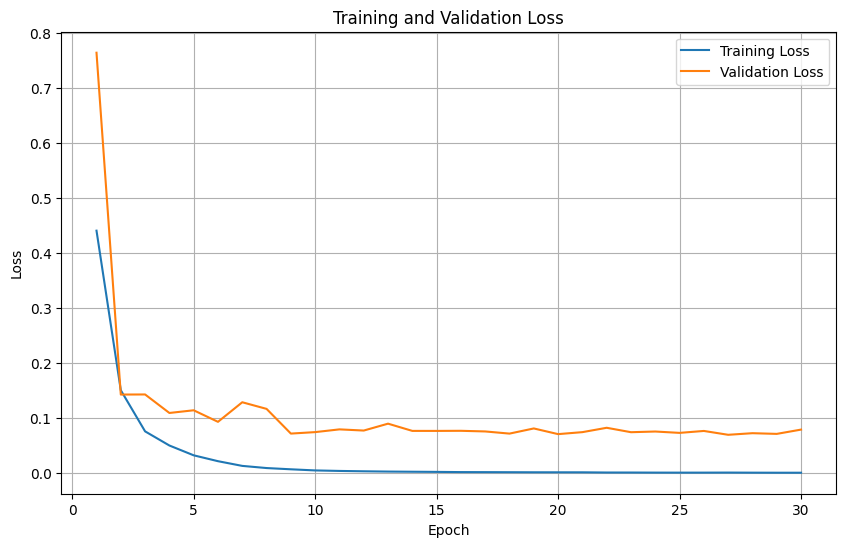

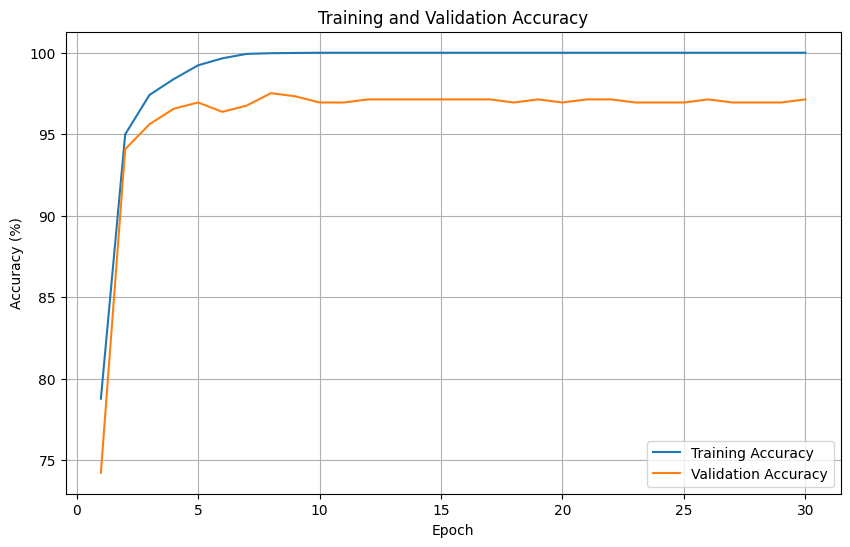

              precision    recall  f1-score   support

     Class 0       0.96      0.58      0.72       234
     Class 1       0.80      0.99      0.88       390

    accuracy                           0.83       624
   macro avg       0.88      0.78      0.80       624
weighted avg       0.86      0.83      0.82       624



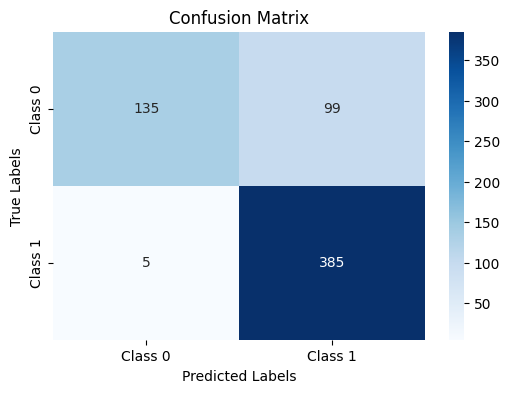

In [6]:
#ACGAN resnet18
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
DATA_ROOT = os.path.join('.', 'ACGAN')

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(train_dataset)
model = ResNet18(in_channels=n_channels, num_classes=n_classes).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
criterion = nn.CrossEntropyLoss()
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
seed = 42
torch.manual_seed(seed)
# Training loop
for epoch in range(NUM_EPOCHS):
    model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, targets in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == targets).sum().item()
        total_train += targets.size(0)

    train_loss = running_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == targets).sum().item()
            total_val += targets.size(0)

    val_loss = running_val_loss / len(val_loader)
    val_accuracy = correct_val / total_val * 100
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Training Loss')
plt.plot(range(1, NUM_EPOCHS + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, NUM_EPOCHS + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, NUM_EPOCHS + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

# Evaluation on test data
all_preds = []
all_targets = []
model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

target_names = ["Class 0", "Class 1"]
report = classification_report(all_targets, all_preds, target_names=target_names)
print(report)

# 生成混淆矩阵
cm = confusion_matrix(all_targets, all_preds)

# 绘制混淆矩阵热图
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



In [12]:
print("Loaded Images Shape:", loaded_imgs.shape)
print("Loaded Labels Shape:", loaded_labels.shape)
print("First Image Data:", loaded_imgs[0])  # 示例：打印第一个图像数据
print("First Label:", loaded_labels[0])    # 示例：打印第一个标签


Loaded Images Shape: torch.Size([6988, 1, 28, 28])
Loaded Labels Shape: torch.Size([6988])
First Image Data: tensor([[[-0.2784, -0.1529, -0.0824, -0.1294, -0.2078, -0.2941, -0.4510,
          -0.6157, -0.7804, -0.5294, -0.3490, -0.0667,  0.2235,  0.4588,
           0.6549,  0.6000,  0.5059,  0.5922,  0.6000,  0.3020, -0.0980,
          -0.2941, -0.5843, -1.0000, -1.0000, -0.9608, -0.9373, -0.9529],
         [ 0.0118,  0.0824,  0.1059,  0.0353, -0.0588, -0.1294, -0.2157,
          -0.3020, -0.2392, -0.1373, -0.1765, -0.0824,  0.1294,  0.3569,
           0.5294,  0.4196,  0.5216,  0.5137,  0.3961,  0.1137, -0.1373,
          -0.2784, -0.5529, -0.9137, -0.9529, -0.9686, -0.9843, -0.9765],
         [ 0.1059,  0.1451,  0.1608,  0.1216,  0.0510,  0.0039, -0.0118,
          -0.0118,  0.0980,  0.2235,  0.1216,  0.0745,  0.1294,  0.2706,
           0.4118,  0.2941,  0.2471,  0.3020,  0.2157,  0.0588, -0.0118,
          -0.1373, -0.3804, -0.5686, -0.9373, -1.0000, -1.0000, -1.0000],
         [-0